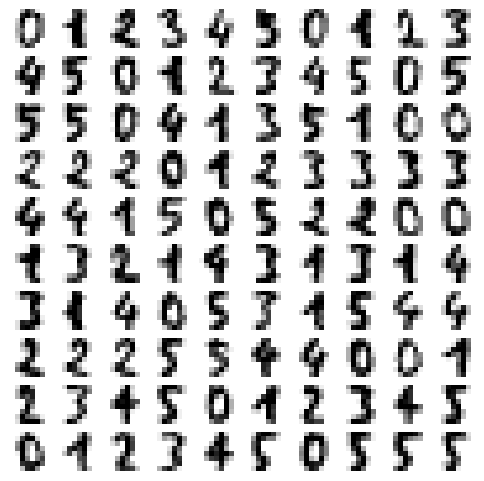

In [4]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause (C) INRIA 2011

from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
# _ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

아래에서, 우리는 숫자 데이터 세트를 포함하기 위해 다른 기술을 참조하십시오. 각 임베딩에 원본 데이터의 투영을 플롯합니다. 또는 숫자가 임베딩 공간에 그룹화되어 있는지, 아니면 공간에 흩어져 있는지 확인할 수 있습니다.

In [5]:
import numpy as np
from matplotlib import offsetbox

from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

아래에서는 다양한 기술을 비교합니다. 그러나 다음과 같은 몇 가지 주의 사항이 있습니다:

랜덤 트리 임베딩은 차원 축소 방법을 적용하는 고차원 표현을 학습하기 때문에 기술적으로 다양한 임베딩 방법이 아닙니다. 그러나 클래스가 선형으로 분리 가능한 표현에 데이터 세트를 캐스팅하는 것이 종종 유용합니다.

선형 판별 분석 및 인접 요소 분석은 감독된 차원 축소 방법입니다. 즉, 다른 방법과 달리 제공된 레이블을 사용합니다.

TSNE는 이 예에서 PCA에 의해 생성된 임베딩으로 초기화됩니다. 임베딩의 글로벌 안정성을 보장합니다. 즉, 임베딩이 무작위 초기화에 의존하지 않습니다.

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "MDS embedding": MDS(
        n_components=2, n_init=1, max_iter=120, n_jobs=2, normalized_stress="auto"
    ),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embeedding": TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

우리가 관심 있는 모든 방법에 대해 선언한 후, 우리는 원래 데이터의 프로젝트를 수행할 수 있습니다.우리는 각 프로젝트를 수행하기 위해 필요한 계산 시간뿐만 아니라 예측 데이터를 저장할 것입니다.

In [7]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...
Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embeedding...
Computing NCA embedding...


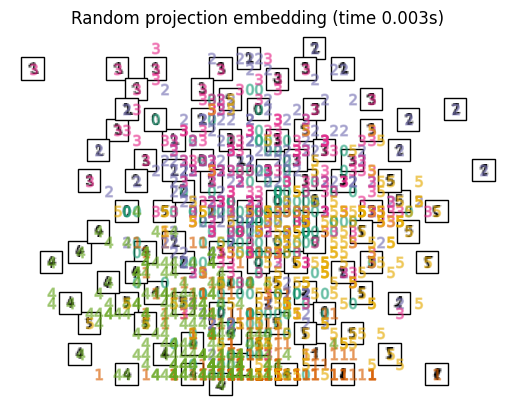

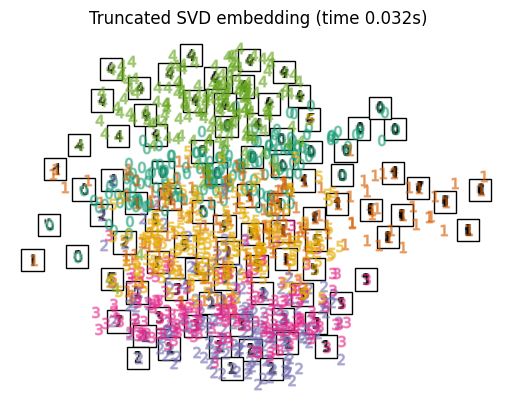

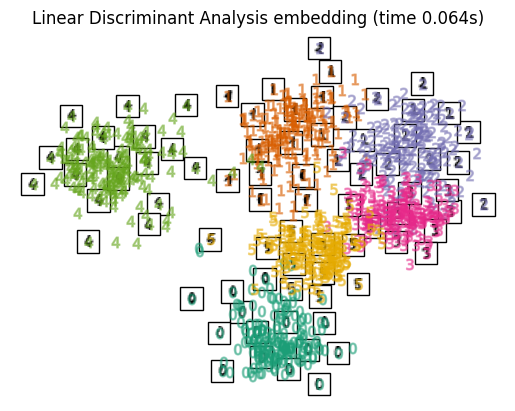

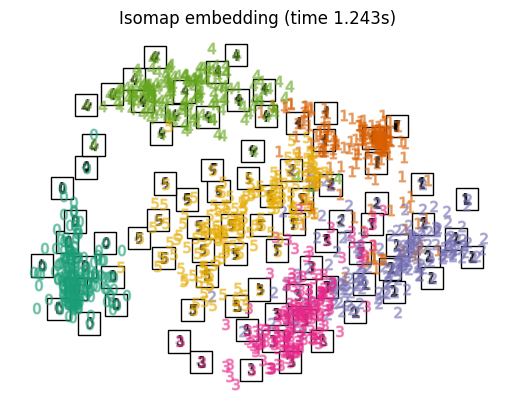

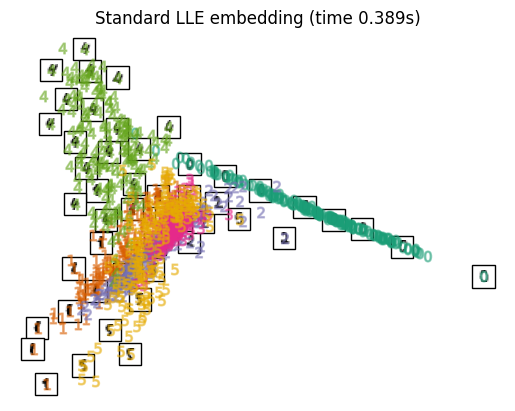

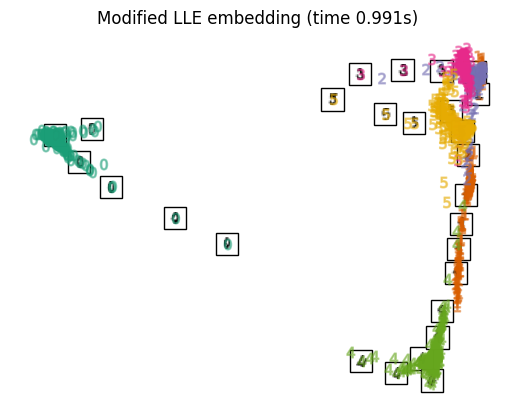

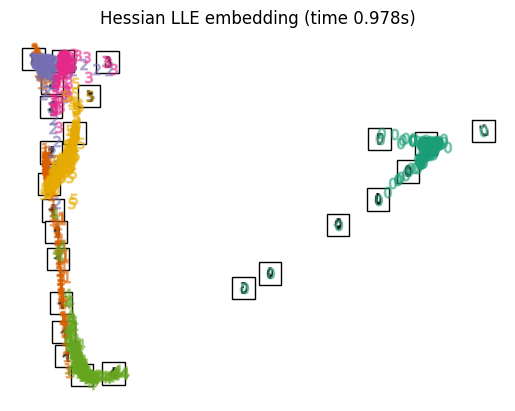

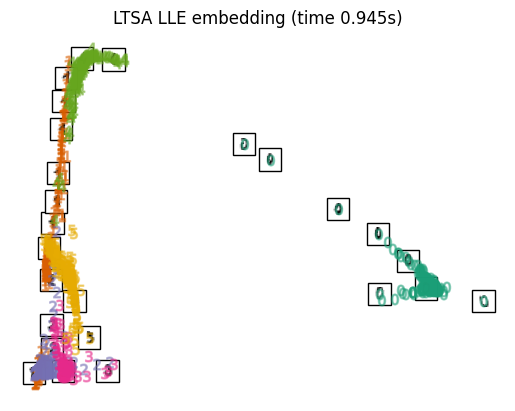

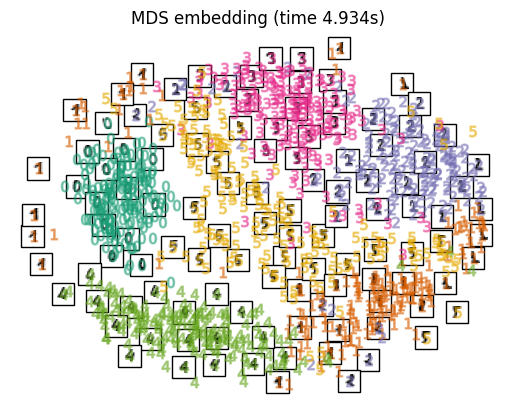

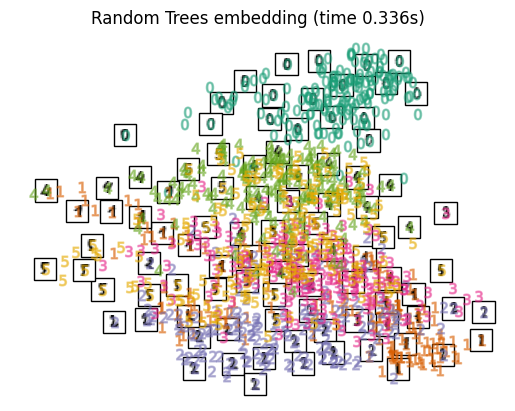

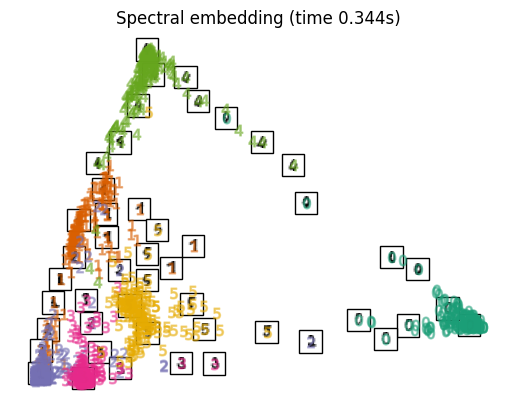

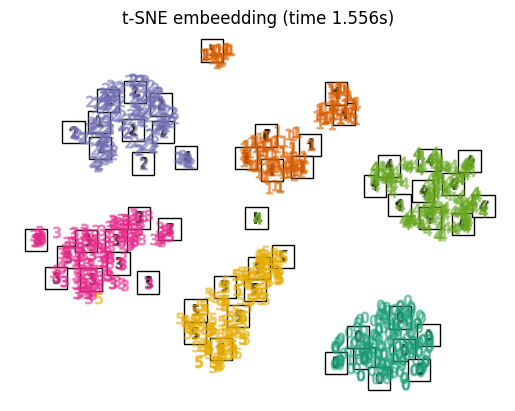

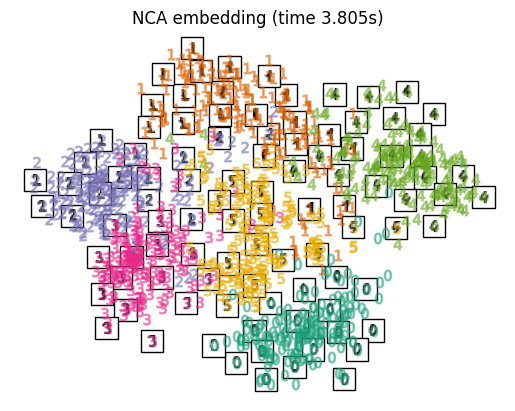

In [8]:
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()